In [2]:
import datetime
import numpy as np
import matplotlib.pylab as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [3]:
from pkg_resources import get_distribution
import platform
print("python", platform.python_version())
print("")
libs = ["numpy", "torch", "torchvision", "matplotlib"]
for lib in libs:
    version = get_distribution(lib).version
    print(lib, version)

python 3.5.2

numpy 1.13.1
torch 0.2.0.post1
torchvision 0.1.9
matplotlib 2.0.2


In [4]:
# RNN-LSTMで正弦波を予測するモデル

In [70]:
# モデルクラス定義

class LSTM(nn.Module):
    def __init__(self, seq_size, hidden_size, out_size):
        # クラスの初期化
        # :param seq_size: 入力時系列のサイズ
        # :param hidden_size: 隠れ層のサイズ
        # :param out_size: 出力層のサイズ
        super(LSTM, self).__init__()
        self.xh = torch.nn.LSTM(seq_size, hidden_size)
        self.hy = torch.nn.Linear(hidden_size, out_size)
        self.hidden_size = hidden_size
        
    def __call__(self, xs):
        # 順伝播を計算する関数
        # :param xs: 入力時系列
        h, self.hidden = self.xh(xs, self.hidden)
        y = self.hy(h)
        return y

    def reset(self):
        # メモリの初期化
        self.hidden = (Variable(torch.zeros(1, 1, self.hidden_size)), Variable(torch.zeros(1, 1, self.hidden_size))) # h, c

In [155]:
# 学習

EPOCH_NUM = 300
HIDDEN_SIZE = 5
BATCH_ROW_SIZE = 100 # 分割した時系列をいくつミニバッチに取り込むか
BATCH_COL_SIZE = 20 # ミニバッチで分割する時系列数
 
# 教師データ
train_data = np.array([np.sin(i*2*np.pi/50) for i in range(50)]*10)
 
# 教師データを変換
train_x, train_t = [], []
for i in range(0, len(train_data)-BATCH_COL_SIZE):
    train_x.append(train_data[i:i+BATCH_COL_SIZE])
    train_t.append(train_data[i+BATCH_COL_SIZE])
train_x = np.array(train_x, dtype="float32")
train_t = np.array(train_t, dtype="float32")
N = len(train_x)

model = LSTM(seq_size=BATCH_COL_SIZE, hidden_size=HIDDEN_SIZE, out_size=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

# 学習開始
print("Train")
st = datetime.datetime.now()
for epoch in range(EPOCH_NUM):
    # ミニバッチ学習
    x, t = [], []
    #  ミニバッチ学習データとして、BATCH_ROW_SIZE個用意する
    for i in range(BATCH_ROW_SIZE):
        index = np.random.randint(0, N) # ランダムな箇所
        x.append(train_x[index]) # BATCH_COL_SIZE分の時系列を取り出す
        t.append(train_t[index])
    x = np.array(x, dtype="float32")
    t = np.array(t, dtype="float32")
    x = Variable(torch.from_numpy(x))
    t = Variable(torch.from_numpy(t))
    total_loss = 0
    model.reset() # メモリの初期化
    y = model(x)
    loss = criterion(y, t)
    loss.backward()
    total_loss += loss.data.numpy()[0]
    optimizer.step()
    if (epoch+1) % 100 == 0:
        ed = datetime.datetime.now()
        print("epoch:\t{}\ttotal loss:\t{}\ttime:\t{}".format(epoch+1, total_loss, ed-st))
        st = datetime.datetime.now()

Train
epoch:	100	total loss:	0.1691248118877411	time:	0:00:08.879125
epoch:	200	total loss:	0.15885528922080994	time:	0:00:08.942392
epoch:	300	total loss:	0.06519095599651337	time:	0:00:08.135251



Predict


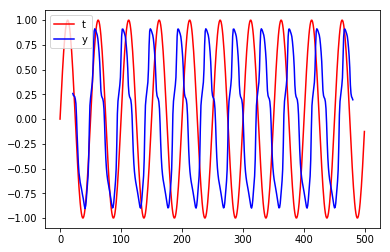

In [156]:
# 予測

print("\nPredict")
predict = np.empty(0) # 予測時系列
inseq_size = 20
inseq = train_data[:inseq_size] # 予測直前までの時系列
for _ in range(N - inseq_size):
    model.reset() # メモリを初期化
    x = np.array([inseq], dtype="float32")
    x = Variable(torch.from_numpy(x))
    y = model(x)
    y = y.data.numpy().reshape(1)[0]
    predict = np.append(predict, y)
    inseq = np.delete(inseq, 0)
    inseq = np.append(inseq, y)

plt.plot(range(len(train_data)), train_data, color="red", label="t")
plt.plot(range(inseq_size+1, N+1), predict, color="blue", label="y")
plt.legend(loc="upper left")
plt.show()